In [1]:
t_delta = 0.01

# Golden dynamics visualization

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

default_dir = os.path.dirname(os.getcwd())
os.chdir(default_dir)
import RLConn as rc
from RLConn import problem_definitions as problems
from RLConn import connectome_utils as connectome_utils

problem = problems.get_five_neuron_oscillation_definition()
# problem = problems.get_four_neuron_oscillation_definition()
m1_target = problem.m1_target

NameError: name 'plot_top_mode' is not defined

In [3]:
print("Shapes of m1: %s" % (m1_target.shape))

Shapes of m1: 500


Text(0.5, 0.98, 'Golden dynamics')

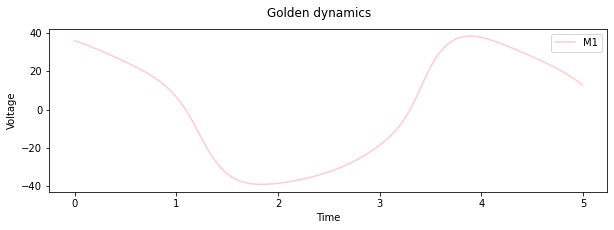

In [13]:
num_timesamples = m1_target.shape[0]

timepoints = np.arange(0, num_timesamples * t_delta, t_delta)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(timepoints, m1_target, label="M1", c ="red", alpha =0.2)
ax.set_xlabel("Time")
ax.set_ylabel("Voltage")
ax.legend()
fig.suptitle("Golden dynamics")

# Initial unoptimized connectome

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Mean error = 22.5172, Summed error  = 11258.6149


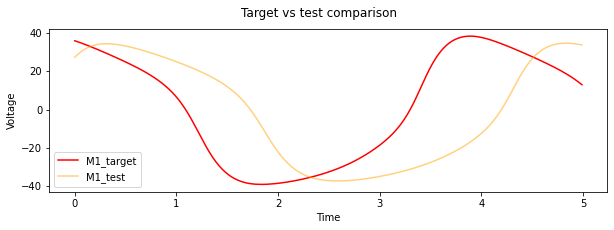

In [14]:
from RLConn import stephen_utils as connectomes

N = problem.N
init_Gg = problem.init_Gg
init_Gs = problem.init_Gs

mean_err, summed_err = rc.utils.compute_problem_score(init_Gg, init_Gs, problem, verbose=False, plot_result=True)
print("Mean error = %.4f, Summed error  = %.4f" % (mean_err, summed_err))

# Perform optimization

In [15]:
eval_times = []
errs = []
num_called = 0
min_err = 1000000

def obj_fun(compact_vec):
  global num_called
  global min_err
  global init_Gg
  global init_Gs
  global eval_times
  global errors
  num_called += 1
  gg_mat, gs_mat = connectomes.compact_to_model_param(compact_vec, N)
  mean_err, summed_err = rc.utils.compute_problem_score(gg_mat, gs_mat, problem,
                                                        plot_result=False, verbose=False)
  # TODO: Train on summed_err or mean?
  err = summed_err
  min_err = min(min_err, err)
  if num_called % 10 == 0:
    print("Evaluation %s, error = %.2f, min_error = %.2f" % (num_called, err, min_err))
    print("Gg = " + str(gg_mat))
    print("Gs = " + str(gs_mat))
    print("delta Gg = " + str((init_Gg - gg_mat).round(2)))
    print("delta Gs = " + str((init_Gs - gs_mat).round(2)))
    eval_times.append(num_called)
    errs.append(err)
  return err

In [16]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import time

N = problem.N
init_cond_compact = connectomes.model_to_compact_param(init_Gg, init_Gs, N)
bnds = [(0, 10)] * len(init_cond_compact)

"""
These methods are discarded:
Doesn't handle bounds. Documentation says: L-BFGS-B, TNC, SLSQP and trust-constr 
- BFGS 
- Powell 
- Nelder-Mead
"""

# See the options from here
# https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.optimize.show_options.html
def optimize_with_SLSQP():
  return minimize(obj_fun, init_cond_compact, method='SLSQP', bounds=bnds,
                  options={'maxiter':100})

def optimize_with_L_BFGS_B():
  return minimize(obj_fun, init_cond_compact, method='L-BFGS-B', bounds=bnds,
                  options={'maxiter':10})

def optimize_with_TNC():
  return minimize(obj_fun, init_cond_compact, method='TNC', bounds=bnds,
                  options={'maxiter':10})

def optimize_with_trust_constr():
  # TODO: Change the opt back to 100
  return minimize(obj_fun, init_cond_compact, method='trust-constr', bounds=bnds,
                  options={'maxiter':1})

def optimize_with_basin_hopping():
  minimizer_kwargs = {"method":"Powell", "bounds":bnds}
  # You can add niter=k to limit the number of bruteforces
  return basinhopping(obj_fun, init_cond_compact, minimizer_kwargs=minimizer_kwargs)
  
start_time = time.time()
res = optimize_with_trust_constr()
print("Total optimization time = %.2fs" % (time.time() - start_time))
print(res)

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

The optimized Gg and Gs are:
[[0.         8.3743041  4.96623333]
 [8.3743041  0.         2.20793276]
 [4.96623333 2.20793276 0.        ]]
[[0.         1.83309678 8.67362672]
 [7.40267886 0.         3.03025043]
 [7.34072357 7.2407879  0.        ]]

Old Gg and Gs are:
[[0.         8.4359949  5.02592623]
 [8.4359949  0.         2.54966248]
 [5.02592623 2.54966248 0.        ]]
[[0.         2.20464863 8.61927097]
 [7.43532239 0.         3.29965467]
 [7.4203678  7.33033482 0.        ]]

The difference matrices are:
[[ 0.         -0.06169081 -0.0596929 ]
 [-0.06169081  0.         -0.34172972]
 [-0.0596929  -0.34172972  0.        ]]
[[ 0.         -0.37155186  0.05435575]
 [-0.03264354  0.         -0.26940424]
 [-0.07964424 -0.08954692  0.        ]]



Text(0.5, 0.98, 'Error trends during optimization')

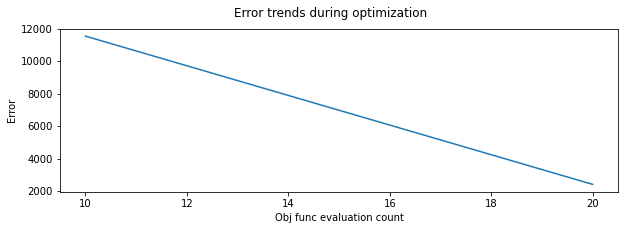

In [17]:
new_Gg, new_Gs = connectomes.compact_to_model_param(res.x, N)
print("The optimized Gg and Gs are:\n%s\n%s\n" % (new_Gg, new_Gs))
print("Old Gg and Gs are:\n%s\n%s\n" % (init_Gg, init_Gs))
print("The difference matrices are:\n%s\n%s\n" % (new_Gg-init_Gg, new_Gs-init_Gs))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_times, errs)
ax.set_xlabel('Obj func evaluation count')
ax.set_ylabel('Error')
fig.suptitle("Error trends during optimization")

# Compare optimized dynamics against golden

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Mean error = 3.8099, Summed error  = 1904.9305


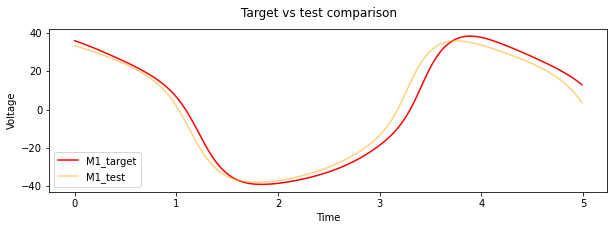

In [18]:
mean_err, summed_err = rc.utils.compute_problem_score(new_Gg, new_Gs,
                                                        problem, verbose=False,)
print("Mean error = %.4f, Summed error  = %.4f" % (mean_err, summed_err))

In [19]:
np.save("/home/stephen/Documents/code/RLConn/m1_target_3_synthetic.npy", m1_target)